In [2]:
import numpy as np
import time
import torch
import torchvision.models as models
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from dataset import FacialImageData
from custom_transforms import ImgMask
import matplotlib.pyplot as plt


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load Data

In [5]:
## create Transform
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(48, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        )
    ]
)

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        )
    ]
)
## create dataset
data_dir = "./data"
train_set = FacialImageData(
    directory=data_dir + "/train",
    transform=train_transform
)
val_set = FacialImageData(
    directory=data_dir + "/test",
    transform=val_transform
)
## create dataloader
## dataloaders automatically sample from dataset
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=8
)
val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=8
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Build Model

In [11]:
## define model
resnet50 = models.resnet50(pretrained=True)
num_classes = 7 ## how many classes in fer?
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)

In [12]:
## define hyperparameters

LR = 0.01
MOMENTUM = 0.9
REG = 1e-3
NUM_EPOCH = 30

## Learning rate decay
LR_DECAY = 0.1
DECAY_EPOCH = 5

In [13]:
## create optimizer
optimizer = optim.SGD(
    resnet50.parameters(),
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=REG
)
## create loss function
loss_func = nn.CrossEntropyLoss().to(device)

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"
best_val_acc = 0
resnet50 = resnet50.to(device)
current_learning_rate = LR

## Initial Loss
#########################################################################
resnet50.eval()
# this help you compute the validation accuracy
total_examples = 0
correct_examples = 0
val_loss = 0 # again, track the validation loss if you want
# disable gradient during validation, which can save GPU memory
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        out = resnet50(inputs)
        loss = loss_func(out, targets)
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(out, 1)
        correct = predicted.eq(targets).sum()
        val_loss += loss.detach().cpu()
        total_examples += targets.shape[0]
        correct_examples += correct.item()
avg_loss = val_loss / len(val_loader)
initial_avg_acc = correct_examples / total_examples
print("Initial loss: %.4f, Initial accuracy: %.4f" % (avg_loss, initial_avg_acc))
#########################################################################
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
# start the training/validation process
print("==> Training starts!")
print("="*50)
for i in range(0, NUM_EPOCH):
    print("Epoch %d:" %i)
    ## Train on the train set
    #####################################################################
    # switch to train mode
    resnet50.train()
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        out = resnet50(inputs)
        loss = loss_func(out, targets)
        # zero the gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(out, 1)
        correct = predicted.eq(targets).sum()
        train_loss += loss.detach().cpu()
        total_examples += targets.shape[0]
        correct_examples += correct.item()
    avg_loss = train_loss / len(train_loader)
    train_loss_hist.append(avg_loss)
    avg_acc = correct_examples / total_examples
    train_acc_hist.append(avg_acc)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    ######################################################################

    # Validate on the validation dataset
    ######################################################################
    # switch to eval mode
    resnet50.eval()
    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    val_loss = 0 # track the validation loss
    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # compute the output and loss
            out = resnet50(inputs)
            loss = loss_func(out, targets)
            # count the number of correctly predicted samples
            # in the current batch
            _, predicted = torch.max(out, 1)
            correct = predicted.eq(targets).sum()
            val_loss += loss.detach().cpu()
            total_examples += targets.shape[0]
            correct_examples += correct.item()
    avg_loss = val_loss / len(val_loader)
    test_loss_hist.append(avg_loss)
    avg_acc = correct_examples / total_examples
    test_acc_hist.append(avg_acc)
    print(
        "Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc)
    )
    ######################################################################

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': resnet50.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'resnet50_on_FER.pth'))
    print('')
    ## decay learning rate
    if i % DECAY_EPOCH == 0 and i != 0:
        current_learning_rate *= LR_DECAY
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_learning_rate
            print(f"Current learning rate has decayed to %f" %current_learning_rate)

print("="*50)
print(
    f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}"
)

Initial loss: 2.2243, Initial accuracy: 0.1485
==> Training starts!
Epoch 0:
Training loss: 1.4065, Training accuracy: 0.4627
Validation loss: 1.1972, Validation accuracy: 0.5460
Saving ...

Epoch 1:
Training loss: 1.1269, Training accuracy: 0.5717
Validation loss: 1.0954, Validation accuracy: 0.5858
Saving ...

Epoch 2:
Training loss: 1.0468, Training accuracy: 0.6035
Validation loss: 1.0792, Validation accuracy: 0.5971
Saving ...

Epoch 3:
Training loss: 0.9944, Training accuracy: 0.6233
Validation loss: 1.0249, Validation accuracy: 0.6151
Saving ...

Epoch 4:
Training loss: 0.9540, Training accuracy: 0.6452
Validation loss: 1.0962, Validation accuracy: 0.6037

Epoch 5:
Training loss: 0.9181, Training accuracy: 0.6537
Validation loss: 1.0621, Validation accuracy: 0.5977

Current learning rate has decayed to 0.001000
Epoch 6:
Training loss: 0.8020, Training accuracy: 0.7003
Validation loss: 0.9596, Validation accuracy: 0.6471
Saving ...

Epoch 7:
Training loss: 0.7605, Training accura

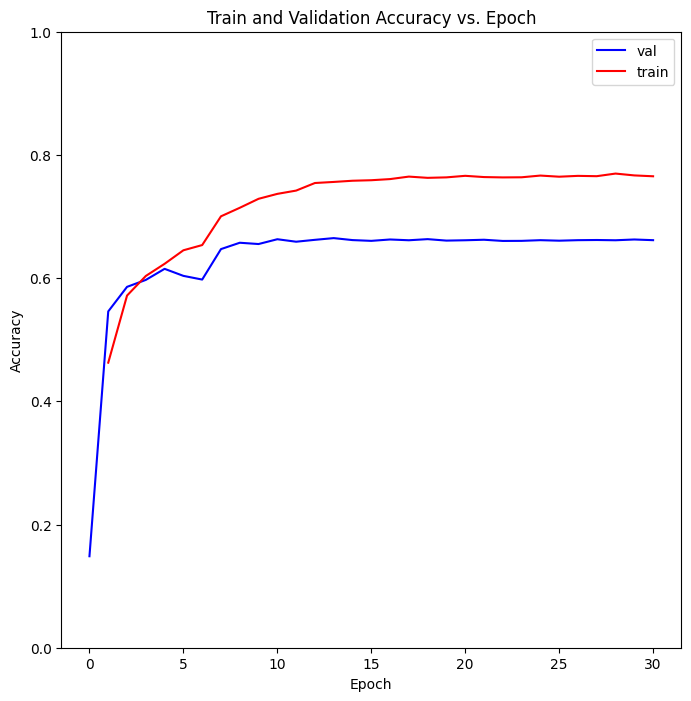

In [14]:
val_plot = [initial_avg_acc]
train_plot = train_acc_hist[:]
val_plot.extend(test_acc_hist[:])
## plots
plt.figure(figsize=(8,8))
plt.plot(range(len(val_plot)), val_plot, "b", label="val")
plt.plot(range(1, len(train_plot) + 1), train_plot, 'r', label="train")
plt.xticks(np.arange(0, max(len(train_plot) + 1, len(val_plot)), 5.0))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs. Epoch")
plt.ylim(0,1)
plt.show()

In [15]:
train_loss_hist

[tensor(1.4065),
 tensor(1.1269),
 tensor(1.0468),
 tensor(0.9944),
 tensor(0.9540),
 tensor(0.9181),
 tensor(0.8020),
 tensor(0.7605),
 tensor(0.7328),
 tensor(0.7135),
 tensor(0.6929),
 tensor(0.6627),
 tensor(0.6566),
 tensor(0.6506),
 tensor(0.6484),
 tensor(0.6457),
 tensor(0.6392),
 tensor(0.6435),
 tensor(0.6444),
 tensor(0.6385),
 tensor(0.6376),
 tensor(0.6374),
 tensor(0.6395),
 tensor(0.6377),
 tensor(0.6370),
 tensor(0.6328),
 tensor(0.6345),
 tensor(0.6321),
 tensor(0.6369),
 tensor(0.6380)]

In [16]:
train_acc_hist

[0.4627468738026403,
 0.5716674213661221,
 0.6035041276254833,
 0.6232540318367062,
 0.6451983698491762,
 0.653662614511129,
 0.700337873140827,
 0.7141662893169389,
 0.7287610157093595,
 0.7367724406980389,
 0.7421017799296388,
 0.7543975756731338,
 0.7561391898011076,
 0.7580897976244383,
 0.7589257724058658,
 0.760771883381518,
 0.7648124281584172,
 0.7627921557699676,
 0.7635584659862761,
 0.7660663903305583,
 0.7640461179421087,
 0.7634888014211572,
 0.763697795116514,
 0.7664843777212721,
 0.7646382667456199,
 0.7659967257654394,
 0.7654742415270472,
 0.7697237799993033,
 0.7667282036991884,
 0.7653349123968094]

In [17]:
test_loss_hist

[tensor(1.1972),
 tensor(1.0954),
 tensor(1.0792),
 tensor(1.0249),
 tensor(1.0962),
 tensor(1.0621),
 tensor(0.9596),
 tensor(0.9426),
 tensor(0.9596),
 tensor(0.9463),
 tensor(0.9636),
 tensor(0.9578),
 tensor(0.9511),
 tensor(0.9531),
 tensor(0.9624),
 tensor(0.9591),
 tensor(0.9589),
 tensor(0.9592),
 tensor(0.9601),
 tensor(0.9661),
 tensor(0.9614),
 tensor(0.9589),
 tensor(0.9534),
 tensor(0.9573),
 tensor(0.9640),
 tensor(0.9548),
 tensor(0.9606),
 tensor(0.9675),
 tensor(0.9592),
 tensor(0.9625)]

In [18]:
test_acc_hist

[0.5459738088604068,
 0.585817776539426,
 0.5971022568960713,
 0.6150738367233213,
 0.6036500417943717,
 0.5976595151852884,
 0.6471161883533018,
 0.6574254667038172,
 0.6553357481192533,
 0.663137364168292,
 0.6590972415714684,
 0.6621621621621622,
 0.6649484536082474,
 0.6617442184452493,
 0.660490387294511,
 0.6627194204513792,
 0.6614655893006408,
 0.6632766787405963,
 0.6609083310114238,
 0.6614655893006408,
 0.6623014767344664,
 0.6603510727222067,
 0.660490387294511,
 0.6616049038729451,
 0.6607690164391196,
 0.6616049038729451,
 0.6618835330175536,
 0.6614655893006408,
 0.6627194204513792,
 0.6616049038729451]